In [1]:
import pandas as pd
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (BertTokenizer, BertConfig, BertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback, set_seed)
from datasets import Dataset
import joblib
import os

c:\Users\MMU\Downloads\FYP_Prototype\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ Load and preprocess data
df = pd.read_csv("final_balanced_dataset_v3.csv")
label_encoder = LabelEncoder()
df["cyberbullying_type"] = label_encoder.fit_transform(df["cyberbullying_type"])
num_labels = len(label_encoder.classes_)

In [3]:
# Save the label encoder
os.makedirs("./cyberbullying_model", exist_ok=True)
joblib.dump(label_encoder, "./cyberbullying_model/cyber_label_encoder.pkl")

['./cyberbullying_model/cyber_label_encoder.pkl']

In [4]:
# ✅ Create 3-way split: Train / Validation / Test
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df["tweet_text"], df["cyberbullying_type"], test_size=0.2, stratify=df["cyberbullying_type"], random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=42
)

In [5]:
# ✅ Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [6]:
# ✅ Tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
def tokenize_function(examples):
    return tokenizer(list(map(str, examples["text"])), padding="max_length", truncation=True, max_length=128)

def prepare_dataset(texts, labels):
    dataset = Dataset.from_pandas(pd.DataFrame({"text": texts, "labels": labels}))
    dataset = dataset.map(tokenize_function, batched=True)
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return dataset

train_dataset = prepare_dataset(train_texts, train_labels)
val_dataset   = prepare_dataset(val_texts, val_labels)
test_dataset  = prepare_dataset(test_texts, test_labels)

Map: 100%|██████████| 14398/14398 [00:08<00:00, 1779.53 examples/s]


In [7]:
# ✅ Custom Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ Catch all extra args
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [8]:
# ✅ Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

In [9]:
# 🔍 Summary Statistics
total_tweets = len(df)
type_distribution = df["cyberbullying_type"].value_counts()
decoded_types = label_encoder.inverse_transform(type_distribution.index)

print(f"\n📊 Total Tweets: {total_tweets}")
print("📚 Cyberbullying Types Distribution:")
for label, count in zip(decoded_types, type_distribution):
    print(f"  - {label}: {count}")



📊 Total Tweets: 71987
📚 Cyberbullying Types Distribution:
  - gender: 12000
  - other_cyberbullying: 12000
  - not_cyberbullying: 12000
  - religion: 11999
  - age: 11994
  - ethnicity: 11994


In [10]:
# ✅ Model init with dropout tuning
def model_init():
    config = BertConfig.from_pretrained(
        "bert-base-multilingual-cased",
        num_labels=num_labels,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.2
    )
    return BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", config=config)

In [11]:
# ✅ Trial setup
trial_params = {
    'learning_rate': 2e-5,
    'num_train_epochs': 15,
    'per_device_train_batch_size': 32,
    'weight_decay': 0.05,
    'warmup_ratio': 0.1
}

set_seed(42)
trial_args = TrainingArguments(
    output_dir="./trial_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=trial_params['learning_rate'],
    per_device_train_batch_size=trial_params['per_device_train_batch_size'],
    per_device_eval_batch_size=64,
    num_train_epochs=trial_params['num_train_epochs'],
    weight_decay=trial_params['weight_decay'],
    warmup_ratio=trial_params['warmup_ratio'],
    logging_dir="./logs/trial_final",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    disable_tqdm=False,
    fp16=True
)

trainer = WeightedLossTrainer(
    model_init=model_init,
    args=trial_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# ✅ Train     
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.869700,0.710762,0.733808,0.706550,0.733942,0.733808
2,0.622200,0.612007,0.772964,0.765264,0.761540,0.772964
3,0.533500,0.523064,0.795624,0.789207,0.788371,0.795624
4,0.479000,0.561418,0.799531,0.788367,0.792553,0.799531
5,0.431700,0.510283,0.812815,0.807842,0.807614,0.812815
6,0.396500,0.480772,0.826880,0.823917,0.824567,0.826880
7,0.365400,0.465307,0.834433,0.829124,0.829785,0.834433
8,0.320600,0.434985,0.843723,0.842710,0.845010,0.843723
9,0.295800,0.467072,0.846762,0.841103,0.845857,0.846762
10,0.283100,0.480728,0.845980,0.841113,0.843963,0.845980


TrainOutput(global_step=21600, training_loss=0.39669308229728983, metrics={'train_runtime': 12920.0606, 'train_samples_per_second': 53.488, 'train_steps_per_second': 1.672, 'total_flos': 4.545834291793152e+16, 'train_loss': 0.39669308229728983, 'epoch': 15.0})

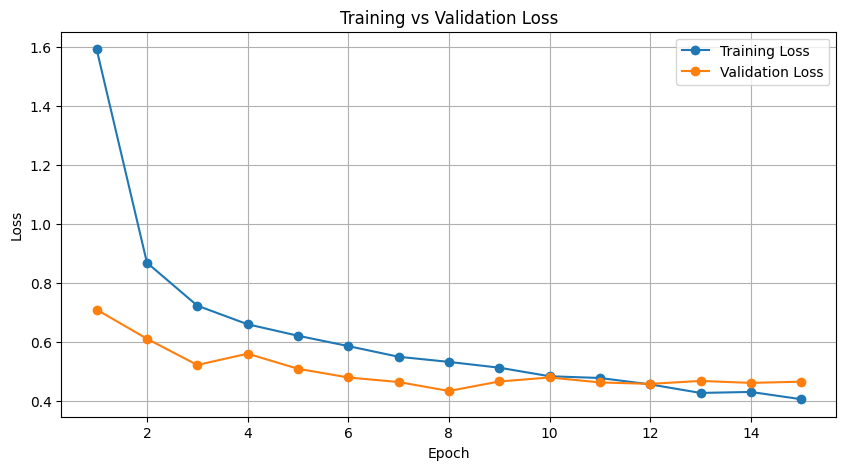

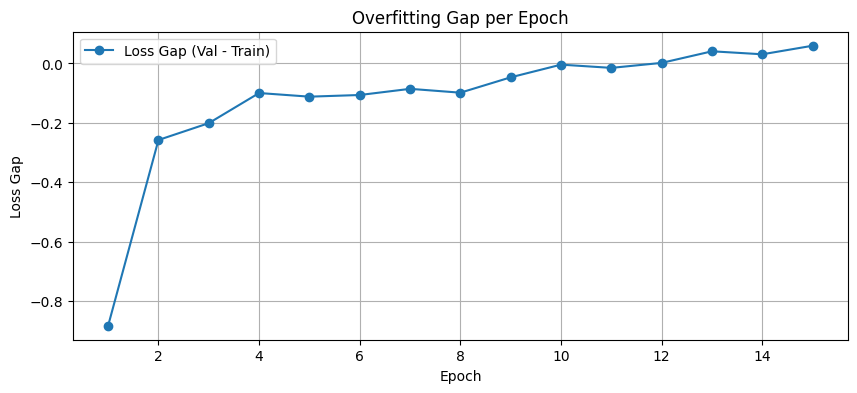

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2399
           1       0.93      0.94      0.94      2399
           2       0.86      0.92      0.89      2400
           3       0.75      0.67      0.71      2400
           4       0.75      0.74      0.75      2400
           5       0.94      0.96      0.95      2400

    accuracy                           0.87     14398
   macro avg       0.86      0.87      0.86     14398
weighted avg       0.86      0.87      0.86     14398



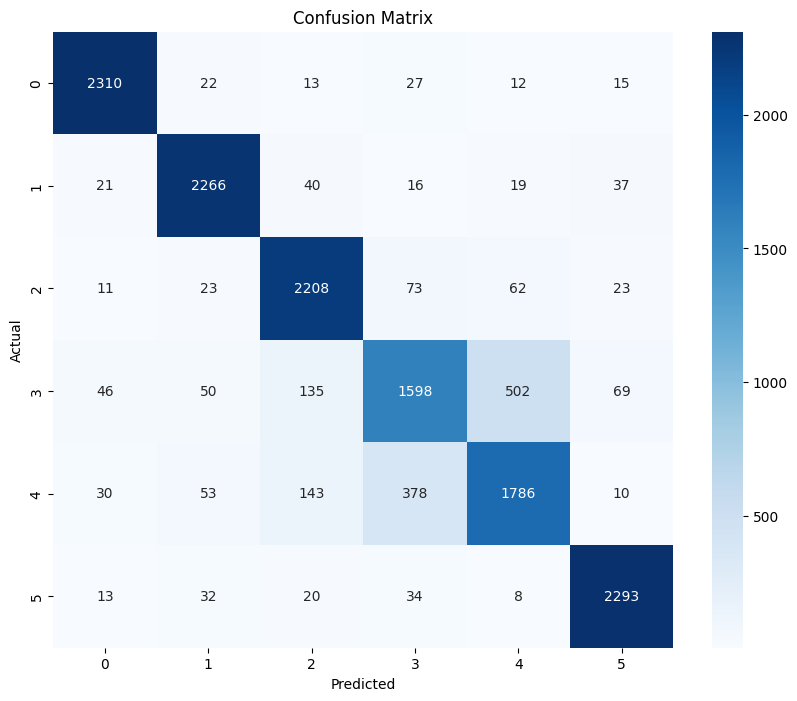

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ✅ 1. Extract clean log history
log_history = trainer.state.log_history

# Separate out training and validation logs
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry and 'eval_loss' not in entry]
val_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]

# Make sure same length
epochs = list(range(1, len(val_loss) + 1))

# ✅ 2. Calculate overfitting gap
loss_gap = [v - t for v, t in zip(val_loss, train_loss[:len(val_loss)])]

# ✅ 3. Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss[:len(epochs)], label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ✅ 4. Plot Overfitting Gap
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss_gap, marker='o', label='Loss Gap (Val - Train)')
plt.xlabel('Epoch')
plt.ylabel('Loss Gap')
plt.title('Overfitting Gap per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# ✅ 5. Classification Report and Confusion Matrix
predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# 🔹 Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 🔹 Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [12]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load model and tokenizer from your best checkpoint
model = BertForSequenceClassification.from_pretrained("./trial_final/checkpoint-21600")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Save them properly
model.save_pretrained("./cyberbullying_model")
tokenizer.save_pretrained("./cyberbullying_tokenizer")

print("✅ Model and Tokenizer saved successfully!")


✅ Model and Tokenizer saved successfully!


In [13]:
import torch
import numpy as np
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
model = BertForSequenceClassification.from_pretrained("./trial_final/checkpoint-21600")  # if epoch 12
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

In [15]:
from sklearn.preprocessing import LabelEncoder
import joblib

label_encoder = joblib.load("cyberbullying_model/cyber_label_encoder.pkl")  # or wherever you saved it
df = pd.read_csv("final_balanced_dataset_v3.csv")
df["cyberbullying_type"] = label_encoder.transform(df["cyberbullying_type"])


In [16]:
from sklearn.model_selection import train_test_split

# Split the dataset again
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df["tweet_text"], df["cyberbullying_type"], test_size=0.2, stratify=df["cyberbullying_type"], random_state=42
)

def tokenize_function(examples):
    return tokenizer(list(map(str, examples["text"])), padding="max_length", truncation=True, max_length=128)

test_dataset = Dataset.from_pandas(pd.DataFrame({"text": test_texts, "labels": test_labels}))
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 14398/14398 [00:08<00:00, 1715.58 examples/s]


In [17]:
from transformers import Trainer

trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)


Classification Report:
                     precision    recall  f1-score   support

                age       0.94      0.97      0.95      2399
          ethnicity       0.92      0.94      0.93      2399
             gender       0.88      0.91      0.89      2400
  not_cyberbullying       0.76      0.66      0.71      2400
other_cyberbullying       0.74      0.76      0.75      2400
           religion       0.94      0.95      0.95      2400

           accuracy                           0.87     14398
          macro avg       0.86      0.87      0.86     14398
       weighted avg       0.86      0.87      0.86     14398



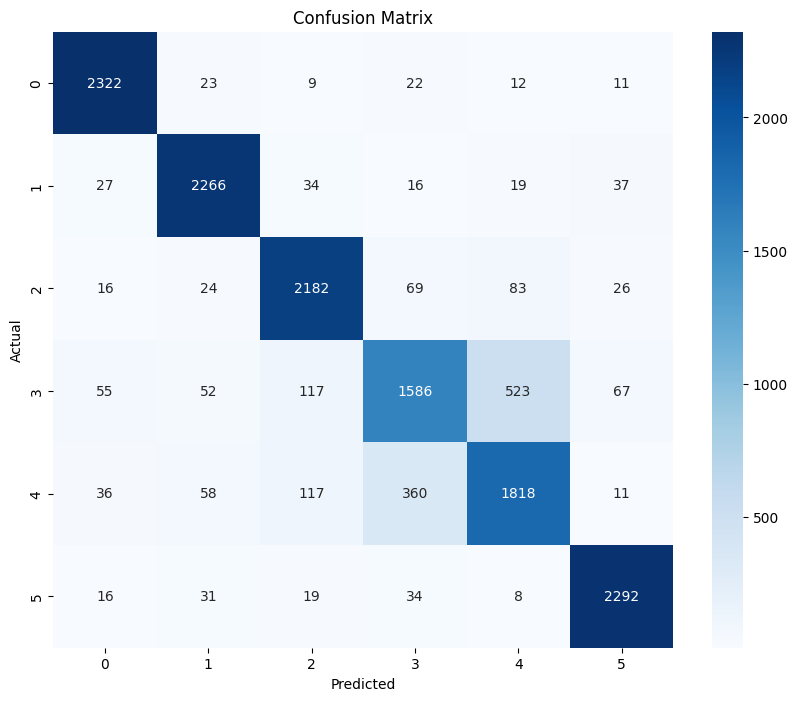

In [18]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
